# Drug Consumption Final Project for COMP 562 - Random Forest Methods
#### by Samantha Anthony

## Import Libraries and Data

In [326]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


drug_labels = ['Alcohol','Amphet','Amyl','Benzos','Caff','Choc','Coke','Crack','Ecstasy','Heroin','Ketamine','Legalh','LSD','Meth','Mushrooms','Nicotine','VSA']
sched_1 = ['Heroin','LSD','Ecstasy','Mushrooms']
sched_2 = ['Amphet','Coke','Crack','Meth']
sched_3 = ['Ketamine']
sched_4 = ['Benzos']
not_controlled_substance = ['Alcohol','Amyl','Caff','Choc','Legalh','Nicotine','VSA']
schedules = ['Sch1','Sch2','Sch3','Sch4', 'SchNA']
personality_labels = ['Nscore','Escore','Oscore','Ascore','Cscore','Impulsive','SS']
demographic_labels = ['Age','Gender','Education','Country','Ethnicity']
target_label = ['Cannabis']

In [2]:
drugs = pd.read_csv('drugs.csv')
print(drugs.shape)
drugs.head()

(1877, 35)


,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,LSD,Meth,Mushrooms,Nicotine,VSA,Sch1,Sch2,Sch3,Sch4,SchNA
0,35-44,1,Professional certificate/ diploma,UK,Mixed-White/Asian,39.0,36.0,42.0,37.0,42.0,...,0,0,0,1,0,0,1,0,1,1
1,25-34,0,Doctorate degree,UK,White,29.0,52.0,55.0,48.0,41.0,...,1,1,0,1,0,1,1,1,0,1
2,35-44,0,Professional certificate/ diploma,UK,White,31.0,45.0,40.0,32.0,34.0,...,0,0,1,0,0,1,0,0,0,1
3,18-24,1,Masters degree,UK,White,34.0,34.0,46.0,47.0,46.0,...,0,0,0,1,0,0,1,1,1,1
4,35-44,1,Doctorate degree,UK,White,43.0,28.0,43.0,41.0,50.0,...,0,0,1,1,0,1,1,0,0,1


## Generate Datasets
data(sch=False, encode='none', bin_out=True, val=False)
- sch: False for individual drugs, True if using drug schedules
- encode: 'onehot' for one-hot encoding categorical (previously 2), 'label' for label encoding categorical (previously 3), 'none' for no encoding
- bin_out: True for binary outputs of weed users, False for all 7 categories of weed users
- val: False does not include a validation set, True does

In [327]:
y = drugs['Cannabis']
X = drugs.drop(target_label, 1)

def data(sch=False, encode='none', bin_out=True, val=False):
    if(sch):
        X_data = X.drop(drug_labels, 1)
    else:
        X_data = X.drop(schedules, 1)
    
    if(encode == 'onehot'):
        X_data = pd.get_dummies(X_data, columns=(demographic_labels))
    elif(encode == 'label'):
        for i in demographic_labels:
            X_data[i] = X_data[i].astype('category')
            X_data[i] = X_data[i].cat.codes
    else:
        for i in demographic_labels:
            X_data[i] = X_data[i].astype('category')
    
    if(val):
        X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.1)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.9)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2)
        
    if(bin_out):
        y_train = np.where((y_train == 'CL0'), 0, 1)
        y_test = np.where((y_test == 'CL0'), 0, 1)
        if(val):
            y_val = np.where((y_val == 'CL0'), 0, 1)
            return X_train, X_val, X_test, y_train, y_val, y_test
        else:
            return X_train, X_test, y_train, y_test
    else:
        if(val):
            return X_train, X_val, X_test, y_train, y_val, y_test
        else:
            return X_train, X_test, y_train, y_test

## Naive Bayes Models
Accuracy = 0.86

#### This first model uses the entire dataset (one-hot encoded X2) to predict which of the 7 classes of weed user (y) each participant is
Accuracy = 0.28

In [135]:
gnb = GaussianNB().fit(X_train2, y_train2)
gnb_predictions = gnb.predict(X_test2)
accuracy = gnb.score(X_test2, y_test2)
print(accuracy)
cm = confusion_matrix(y_test2, gnb_predictions)
cm

0.28191489361702127


array([[27,  6,  0,  1,  0,  2,  0],
       [ 8,  5,  0,  2,  0,  2,  0],
       [ 5,  6,  0,  2,  2, 14,  0],
       [ 1,  2,  0,  4,  0, 15,  0],
       [ 0,  2,  0,  0,  2, 11,  0],
       [ 0,  1,  1,  2,  0, 15,  0],
       [ 0,  1,  1,  2,  7, 39,  0]], dtype=int64)

It appears that a Naive Bayes Model on this many outputs, with one-hot encoded variables, is not very accurate of a predictor of the 7 weed user types.

####  This second model uses the entire dataset (label encoded X3) to predict which of the 7 classes of weed user (y) each participant is
Accuracy = 0.28

In [137]:
gnb = GaussianNB().fit(X_train3, y_train3)
gnb_predictions = gnb.predict(X_test3)
accuracy = gnb.score(X_test3, y_test3)
print(accuracy)
cm = confusion_matrix(y_test3, gnb_predictions)
cm

0.2765957446808511


array([[36,  0,  0,  0,  0,  0,  0],
       [ 9,  2,  1,  0,  5,  0,  0],
       [ 6,  5,  1,  0, 17,  0,  0],
       [ 1,  2,  0,  0, 19,  0,  0],
       [ 2,  0,  0,  0, 13,  0,  0],
       [ 0,  1,  0,  0, 18,  0,  0],
       [ 0,  2,  1,  0, 47,  0,  0]], dtype=int64)

#### This third model looks at the label encoded dataset (X3) to predict which of two classes of weed user (y_bin) each participant is
Accuracy = 0.85

In [108]:
gnb = GaussianNB().fit(X_train3, y_bin_train3)
gnb_predictions = gnb.predict(X_test3)
accuracy = gnb.score(X_test3, y_bin_test3)
print(accuracy)
cm = confusion_matrix(y_bin_test3, gnb_predictions)
cm

0.8457446808510638


array([[ 36,   0],
       [ 29, 123]], dtype=int64)

#### This fourth model uses only the other drugs (X[drug_labels]) to predict which of two classes of weed user (y_bin) each participant is
Accuracy = 0.86

In [148]:
clf = CategoricalNB().fit(X_train[drug_labels], y_bin_train)
clf_predictions = clf.predict(X_test[drug_labels])
accuracy = clf.score(X_test[drug_labels], y_bin_test)
print(accuracy)
cm = confusion_matrix(y_bin_test, clf_predictions)
cm

0.8563829787234043


array([[ 36,   0],
       [ 27, 125]], dtype=int64)

This shows that when using the Naive Bayes model, the demographic data is not contributing much to the model, and the drugs are a better predictor.

#### This fifth model uses only the scheduling (X_sch) to predict which of two classes of weed user (y_bin) each participant is
Accuracy = 0.86

In [173]:
clf = CategoricalNB().fit(X_train_sch[schedules], y_bin_train)
clf_predictions = clf.predict(X_test_sch[schedules])
accuracy = clf.score(X_test_sch[schedules], y_bin_test)
print(accuracy)
cm = confusion_matrix(y_bin_test, clf_predictions)
cm

0.8617021276595744


array([[ 36,   0],
       [ 26, 126]], dtype=int64)

#### Overall, it seems that the most accurate Naive Bayes model was using the schedule class of drugs  to predict the binary output of whether or not a person is a weed user (~0.86 accuracy). This will be used as a baseline for comparing the effectiveness of the other models.

In [179]:
imps = permutation_importance(clf, X_train_sch[schedules], y_bin_train)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train_sch[schedules].shape[1]):
    print("%d. %s (%f)" % (f + 1, schedules[indices[f]], importances[indices[f]]))

Feature ranking:
1. Sch1 (0.075017)
2. Sch2 (0.059161)
3. Sch3 (0.013458)
4. SchNA (0.000000)
5. Sch4 (0.000000)


Using permutation importance, we can determine from this model that using a Schedule 1 drug was the biggest predictor of being a weed user, followed by Schedule 2 and Schedule 3.

## KNN
Accuracy = 0.89

In [352]:
X_train, X_test, y_train, y_test = data(sch=True)
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train[schedules], y_train)
predictions = neigh.predict(X_test[schedules])
neigh.score(X_test[schedules], y_test)

0.848404255319149

In [359]:
X_train, X_test, y_train, y_test = data(encode='label')
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train[drug_labels+demographic_labels], y_train)
neigh.score(X_test[drug_labels+demographic_labels], y_test)

0.8670212765957447

In [371]:
X_train, X_test, y_train, y_test = data()
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train[drug_labels], y_train)
neigh.score(X_test[drug_labels], y_test)

0.8856382978723404

## Random Forest

- Base model of 1 Decision Tree: 0.81 accuracy, AUC 0.75
- Random Forest: 0.89 accuracy, AUC 0.94

In [376]:
X_train, X_test, y_train, y_test = data(encode='onehot')

##### Single Decision Tree

In [382]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print(f'Model Accuracy: {tree.score(X_train, y_train)}')
print("Accuracy:", tree.score(X_test, y_test))
roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])

Model Accuracy: 1.0
Accuracy: 0.8164893617021277


0.7542502004811548

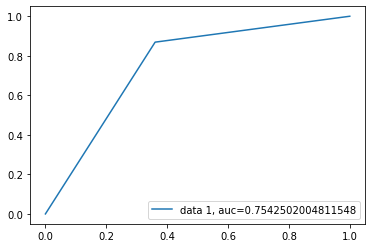

In [383]:
y_pred_proba = tree.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

##### Random Forest

In [380]:
model = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')
model.fit(X_train, y_train)
rf_predictions = model.predict(X_test)
rf_probs = model.predict_proba(X_test)[:, 1]
print("Accuracy:", model.score(X_test, y_test))

roc_value = roc_auc_score(y_test, rf_probs)
print("AUC", roc_value)

Accuracy: 0.8856382978723404
AUC 0.9427826784282276


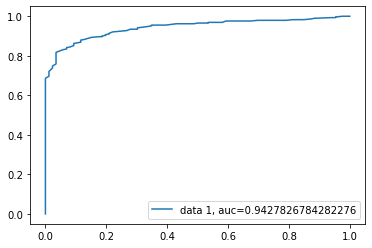

In [381]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

##  XGBoost Model
Accuracy = 0.87 - Redo Later

#### This model uses only the drug schedules to predict a binary output of weed user
Accuracy = 0.86

C:\Users\saman\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\saman\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:25:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 86.17%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

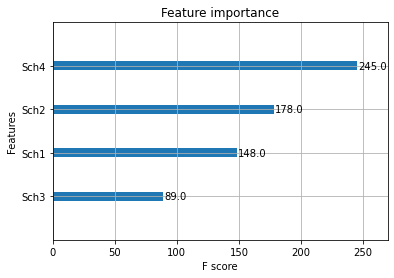

In [100]:
model = xgb.XGBClassifier()
model.fit(X_train_sch[schedules], y_bin_train)
y_pred = model.predict(X_test_sch[schedules])
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_bin_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
xgb.plot_importance(model)

#### This model uses the drug labels to predict the binary type of weed user
Accuracy = 0.87

C:\Users\saman\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\saman\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:27:47] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 87.23%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

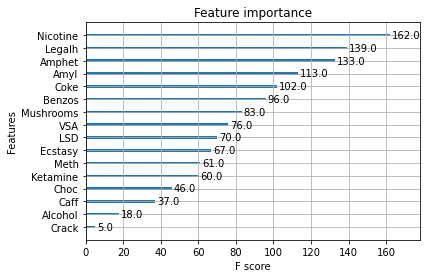

In [104]:
model = xgb.XGBClassifier()
model.fit(X_train[drug_labels], y_bin_train)
y_pred = model.predict(X_test[drug_labels])
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_bin_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
xgb.plot_importance(model)

#### This model uses the drug labels to predict the 7 classifications of weed user
Accuracy = 0.36

C:\Users\saman\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\saman\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[21:33:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 36.17%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

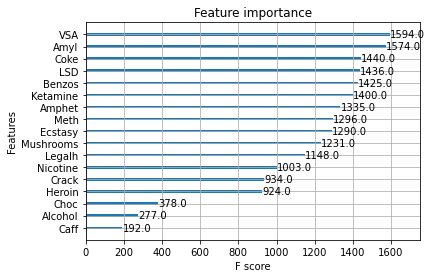

In [110]:
model = xgb.XGBClassifier()
model.fit(X_train[drug_labels], y_train)
y_pred = model.predict(X_test[drug_labels])
accuracy = np.sum(y_pred == y_test) / y_pred.shape[0]
print("Accuracy: %.2f%%" % (accuracy * 100.0))
xgb.plot_importance(model)

#### This model uses the one-hot encoded data (2) to predict 7 weed user classes
Accuracy = 0.40

#### This model uses the one-hot encoded data (2) to predict binary weed user
Accuracy = 0.88

[21:42:43] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 87.77%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

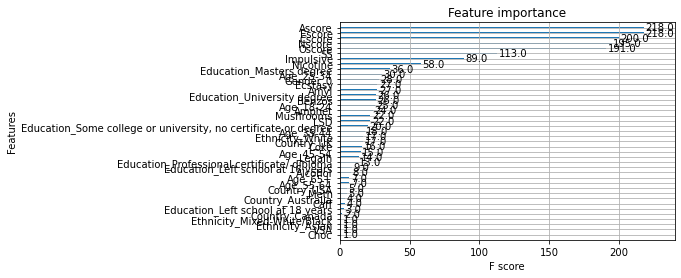

In [118]:
model = xgb.XGBClassifier()
model.fit(X_train2, y_bin_train)
y_pred = model.predict(X_test2)
accuracy = np.sum(y_pred == y_bin_test) / y_pred.shape[0]
print("Accuracy: %.2f%%" % (accuracy * 100.0))
xgb.plot_importance(model)

#### 

#### 